In [1]:
import pathlib

data_dir = pathlib.Path('data')
print(f"Corrected data directory: {data_dir}")

if data_dir.exists():
    print("Directory exists")
else:
    print("Directory does not exist")

all_files = list(data_dir.glob('**/*'))
print(f"Total files found: {len(all_files)}")

print("First few files:")
for file in all_files[:5]:
    print(file)

image_files = list(data_dir.glob('**/*.png'))
image_count = len(image_files)
print(f"Total image files found: {image_count}")

Corrected data directory: data
Directory exists
Total files found: 836
First few files:
data/unicorn
data/horse
data/unicorn/output_new_0050.png
data/unicorn/2025-01-20_13-41-43_4122.png
data/unicorn/output_new_0035.png
Total image files found: 556


In [2]:
image_files = list(data_dir.glob('*/*.png'))
image_count = len(image_files)
print(image_count)

556


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2025-02-09 12:29:00.646872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 12:29:00.654314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739100540.663420  139146 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739100540.666238  139146 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 12:29:00.675917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
horses = list(data_dir.glob('horse/*'))
PIL.Image.open(str(horses[0]))

UnidentifiedImageError: cannot identify image file 'data/horse/01_069.png:Zone.Identifier'

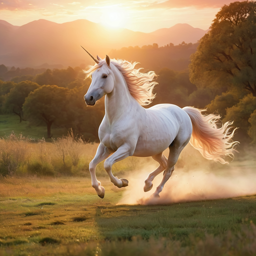

In [5]:
unicorns = list(data_dir.glob('unicorn/*'))
PIL.Image.open(str(unicorns[0]))

In [7]:
image_size = (224, 224)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

# Weitere Teilung in Validation & Test
val_batches = int(len(val_test_ds) * 0.67)  # 67% Validation, 33% Test

val_ds = val_test_ds.take(val_batches)  # Validation-Set (20%)
test_ds = val_test_ds.skip(val_batches)  # Test-Set (10%)

# Kontrolle
print(f"Training Batches: {len(train_ds)}")
print(f"Validation Batches: {len(val_ds)}")
print(f"Test Batches: {len(test_ds)}")

Found 556 files belonging to 2 classes.
Using 390 files for training.
Found 556 files belonging to 2 classes.
Using 166 files for validation.
Training Batches: 25
Validation Batches: 7
Test Batches: 4


In [8]:
class_names = train_ds.class_names
print(class_names)

['horse', 'unicorn']


2025-02-09 12:29:31.105453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


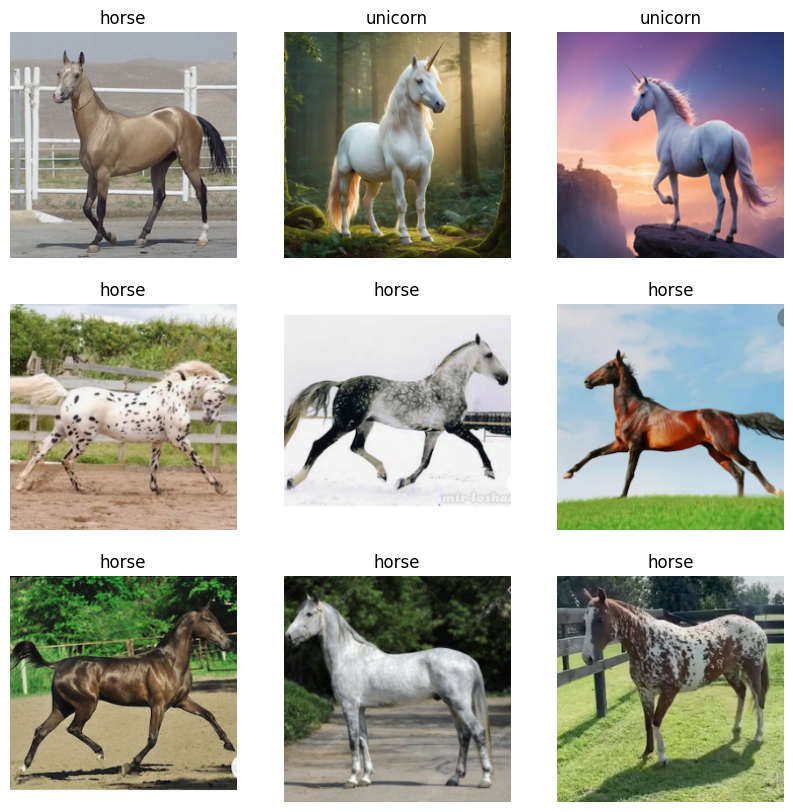

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


# ResNEt 50

In [13]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50

# Vortrainiertes ResNet50 Modell laden
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# ResNet50 einfrieren
for layer in base_model.layers:
    layer.trainable = False

# Klassifikationskopf für Pferde vs. Einhörner
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# Modell kompilieren
# model.compile(optimizer=Adam(learning_rate=0.00005),
#               loss="binary_crossentropy",
#               metrics=["accuracy"])

# Modell kompilieren
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"])


epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20


I0000 00:00:1739100661.870424  139835 service.cc:148] XLA service 0x7f551004d340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739100661.870456  139835 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-02-09 12:31:01.959981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739100662.515758  139835 cuda_dnn.cc:529] Loaded cuDNN version 90300


 8/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6639 - loss: 0.8994

I0000 00:00:1739100665.277546  139835 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8087 - loss: 0.5157

2025-02-09 12:31:06.535516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5277_0', 8 bytes spill stores, 8 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.8176 - loss: 0.4919 - val_accuracy: 0.9911 - val_loss: 0.0190
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9911 - val_loss: 0.0128
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9911 - val_loss: 0.0166
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 7.6913e-04 - val_accuracy: 0.9911 - val_loss: 0.0181
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 4.7439e-04 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 5.2550e-04 - val_accuracy: 0.9911 - val_loss: 0.0143
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9911 

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,162,117 (95.99 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,049,604 (4.00 MB)

# Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2025-02-09 12:31:47.390459: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


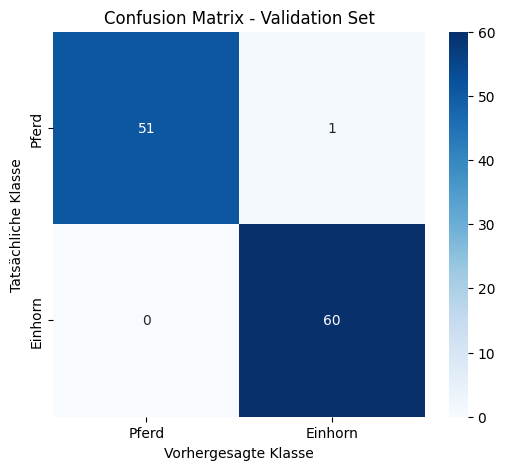

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Vorhersagen auf dem Validierungsset machen
y_true = []
y_pred = []

# Durch alle Batches des Validierungssets iterieren
for images, labels in val_ds:
    preds = model.predict(images)  # Vorhersagen machen
    preds = np.round(preds).flatten()  # Rundet Wahrscheinlichkeiten auf 0 oder 1
    y_pred.extend(preds)
    y_true.extend(labels.numpy())  # Echte Labels speichern

# Confusion Matrix berechnen
cm = confusion_matrix(y_true, y_pred)

# Visualisierung der Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pferd", "Einhorn"], yticklabels=["Pferd", "Einhorn"])
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Confusion Matrix - Validation Set")
plt.show()

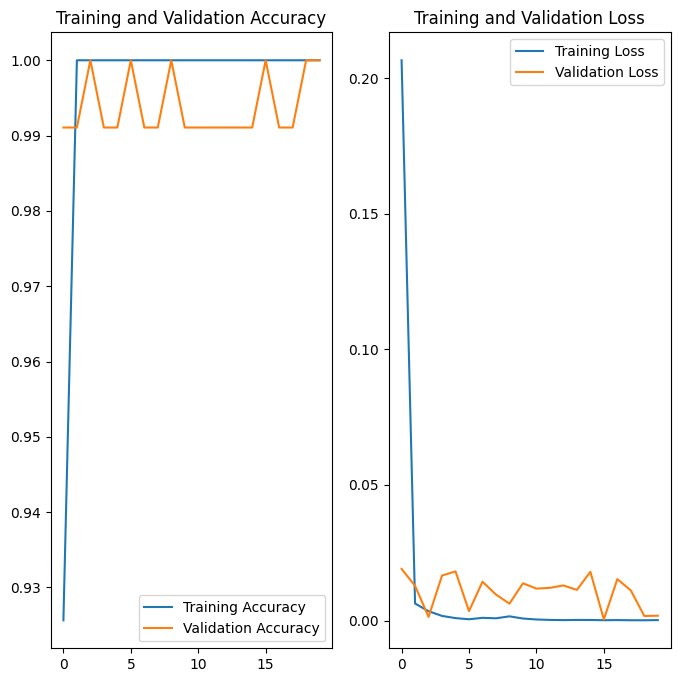

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Data Augemtation

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(image_size[0], image_size[1], 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
  ]
)

/home/timo/Machine-Learning-WiSe2425/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# model.compile(optimizer=Adam(learning_rate=0.00005),
#               loss="binary_crossentropy",
#               metrics=["accuracy"])

# Modell kompilieren
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"])


epochs = 16

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7073 - loss: 0.9842 - val_accuracy: 0.9554 - val_loss: 0.1391
Epoch 2/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9870 - loss: 0.0687 - val_accuracy: 0.9911 - val_loss: 0.0179
Epoch 3/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9943 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 4/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9990 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 5/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9989 - loss: 0.0084 - val_accuracy: 0.9911 - val_loss: 0.0126
Epoch 6/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 7/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 8/16
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9998 - loss: 0.0052 - val_accuracy: 1.0000 - v

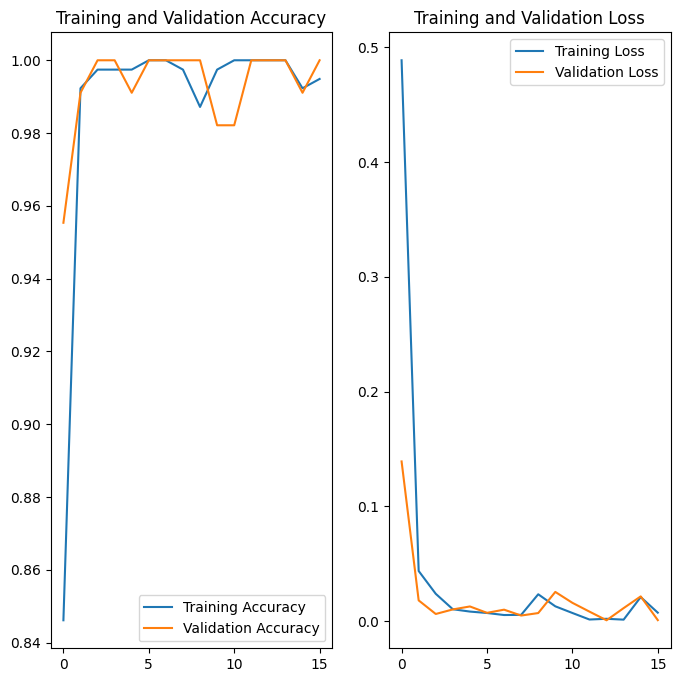

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 1.2312e-04 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 2.4837e-05 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 1.4613e-04 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 9.2427e-05 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 3.4011e-05 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 1.8436e-05 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 8.6664e-05 - val_accuracy: 1.0000 - val_loss: 7.7125e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 9

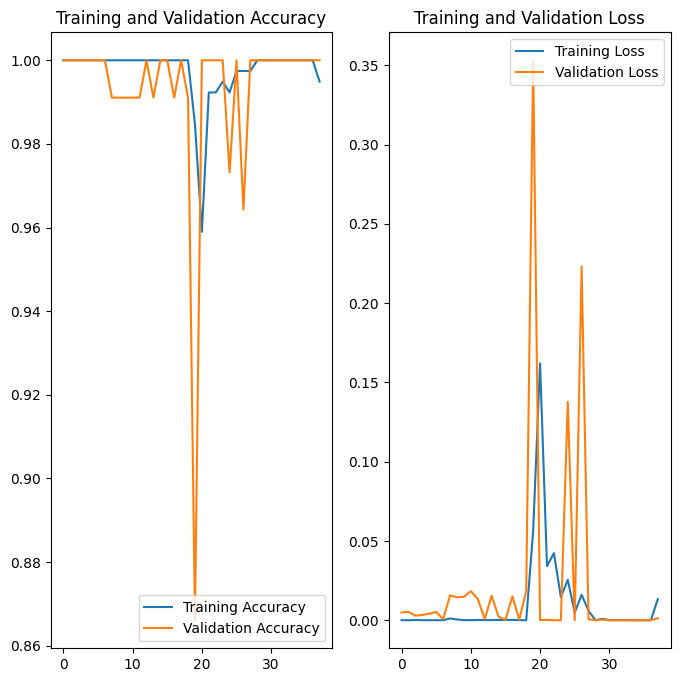

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
